In [1]:
import os
import zipfile
import requests
import glob
import sys
import re
import time

import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions as mobile_decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions as inception_decode_predictions

from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import regularizers


%matplotlib inline

2025-01-02 17:44:51.975303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735857892.094990  201431 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735857892.146101  201431 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 17:44:52.367151: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Getting python version
print(sys.version)

3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]


In [3]:
#Getting tensorflow version
tf.__version__

'2.18.0'

In [4]:
#Checking that Tensorflow detects a GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
if gpus:
    try:
        # Restrict TensorFlow to only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [6]:
# Check if the TF_GPU_ALLOCATOR environment variable is set
gpu_allocator = os.environ.get('TF_GPU_ALLOCATOR')

if gpu_allocator is None:
    print("Warning: The TF_GPU_ALLOCATOR environment variable is not set. This variable determines how TensorFlow manages GPU memory allocation."
          "Setting it to 'cuda_malloc_async' can improve performance on NVIDIA GPUs by reducing memory fragmentation during model training. "
          " Please consider setting the variable before running the model (export TF_GPU_ALLOCATOR=cuda_malloc_async)")
else:
    print(f"TF_GPU_ALLOCATOR is set to: {gpu_allocator}")

TF_GPU_ALLOCATOR is set to: cuda_malloc_async


In [7]:
# Check if the TF_XLA_FLAGS environment variable is set
xla_flags = os.environ.get('TF_XLA_FLAGS')

if xla_flags is None:
    print("Warning: The TF_XLA_FLAGS environment variable is not set. This varialbe is used in TensorFlow to configure the behavior of the "
          "Accelerated Linear Algebra (XLA) compiler. XLA is an optimization framework that compiles TensorFlow computations"
          " to improve performance, particularly for deep learning models."
          " Please consider setting the variable before running the model (export TF_XLA_FLAGS='--tf_xla_enable_xla_devices')")
else:
    print(f"TF_XLA_FLAGS is set to: {xla_flags}")

TF_XLA_FLAGS is set to: --tf_xla_enable_xla_devices


In [8]:
#Enabling Just-In-Time computation (during the execution of this notebook this seemed to speed up computations)
tf.config.optimizer.set_jit(True) 

In [9]:
#set mixed precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [10]:
#setting seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [11]:
#hide some warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [12]:
# Start timer to measure execution time
start_time = time.time()

# Download images to train our model

In [13]:
def create_kaggle_json():

    kaggle_json_content = f'{{"username":"{os.getenv("KAGGLE_USERNAME")}", "key":"{os.getenv("KAGGLE_KEY")}"}}'

    kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json") 
    os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)  

    with open(kaggle_json_path, 'w') as f:
        f.write(kaggle_json_content)

    os.chmod(kaggle_json_path, 0o600)  # Permissions to allow only the user to access the file

In [14]:
!pip install kagglehub

In [15]:
import kagglehub

In [16]:
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/devel/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1


# EDA

In [17]:
# The small version of this dataset was extensibly analyzed in the notebook 1, but we still need to figure out how similiar 
# is this version of the dataset to the one we used for notebook 1

In [18]:
dataset_dir = f'{path}/fashion-dataset'
csv_file_path = F'{dataset_dir}/styles.csv'

In [19]:
# Read the first few rows of the CSV to inspect its structure
preview_data = pd.read_csv(csv_file_path, nrows=5)
print(preview_data.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1  2012  Casual             Peter England Men Party Blue Jeans  
2  2016  Casual                       Titan Women Silver Watch  
3  2011  Casual  Manchester United Men Solid Black Track Pants  
4  2012  Casual                          Puma Men Grey T-shirt  


In [20]:
# the data is structured exactly as we had seen before

In [21]:
#read dataset and skip some bad lines
columns=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'productDisplayName']
data = pd.read_csv(csv_file_path,  usecols=columns, on_bad_lines='skip')
data.head()

id gender masterCategory subCategory  articleType  \
0  15970    Men        Apparel     Topwear       Shirts   
1  39386    Men        Apparel  Bottomwear        Jeans   
2  59263  Women    Accessories     Watches      Watches   
3  21379    Men        Apparel  Bottomwear  Track Pants   
4  53759    Men        Apparel     Topwear      Tshirts   

                              productDisplayName  
0               Turtle Check Men Navy Blue Shirt  
1             Peter England Men Party Blue Jeans  
2                       Titan Women Silver Watch  
3  Manchester United Men Solid Black Track Pants  
4                          Puma Men Grey T-shirt

In [22]:
#Adding a new column to dataset, with the file name
data['filename'] = data['id'].astype(str)+'.jpg'
data['filename'] = data['filename'].str.strip() 
data['filename'] = data['filename'].str.lower()  
data.head()

id gender masterCategory subCategory  articleType  \
0  15970    Men        Apparel     Topwear       Shirts   
1  39386    Men        Apparel  Bottomwear        Jeans   
2  59263  Women    Accessories     Watches      Watches   
3  21379    Men        Apparel  Bottomwear  Track Pants   
4  53759    Men        Apparel     Topwear      Tshirts   

                              productDisplayName   filename  
0               Turtle Check Men Navy Blue Shirt  15970.jpg  
1             Peter England Men Party Blue Jeans  39386.jpg  
2                       Titan Women Silver Watch  59263.jpg  
3  Manchester United Men Solid Black Track Pants  21379.jpg  
4                          Puma Men Grey T-shirt  53759.jpg

In [23]:
images_dir = f'{dataset_dir}/images'

In [24]:
# Checking for invalid filenames and getting information about images
invalid_filenames = []
image_sizes = []
all_images = []
small_images = []
for filename in data['filename']:
    file_path = os.path.join(images_dir, filename)
    if not os.path.exists(file_path):
        invalid_filenames.append(filename)
    else:
        img = Image.open(file_path)
        dimensions = img.size
        width, height = dimensions
        if width < 1000 or height<1000:
            small_images.append((filename, dimensions))
        image_sizes.append(dimensions)
print("Invalid filenames:\n")
for invalid in invalid_filenames:
    print(invalid)

Invalid filenames:

39403.jpg
39410.jpg
39401.jpg
39425.jpg
12347.jpg


In [25]:
# This are the same file that were missing on the smaller version of the dataset

In [26]:
#There are some missing images, we will just erase their information from the dataset
data_cleaned = data[~data['filename'].isin(invalid_filenames)]
print(f'Total images that will be used as input: {len(data_cleaned)}')

Total images that will be used as input: 44441


Displaying image corresponding to the article 'Turtle Check Men Navy Blue Shirt' of type 'Shirts'


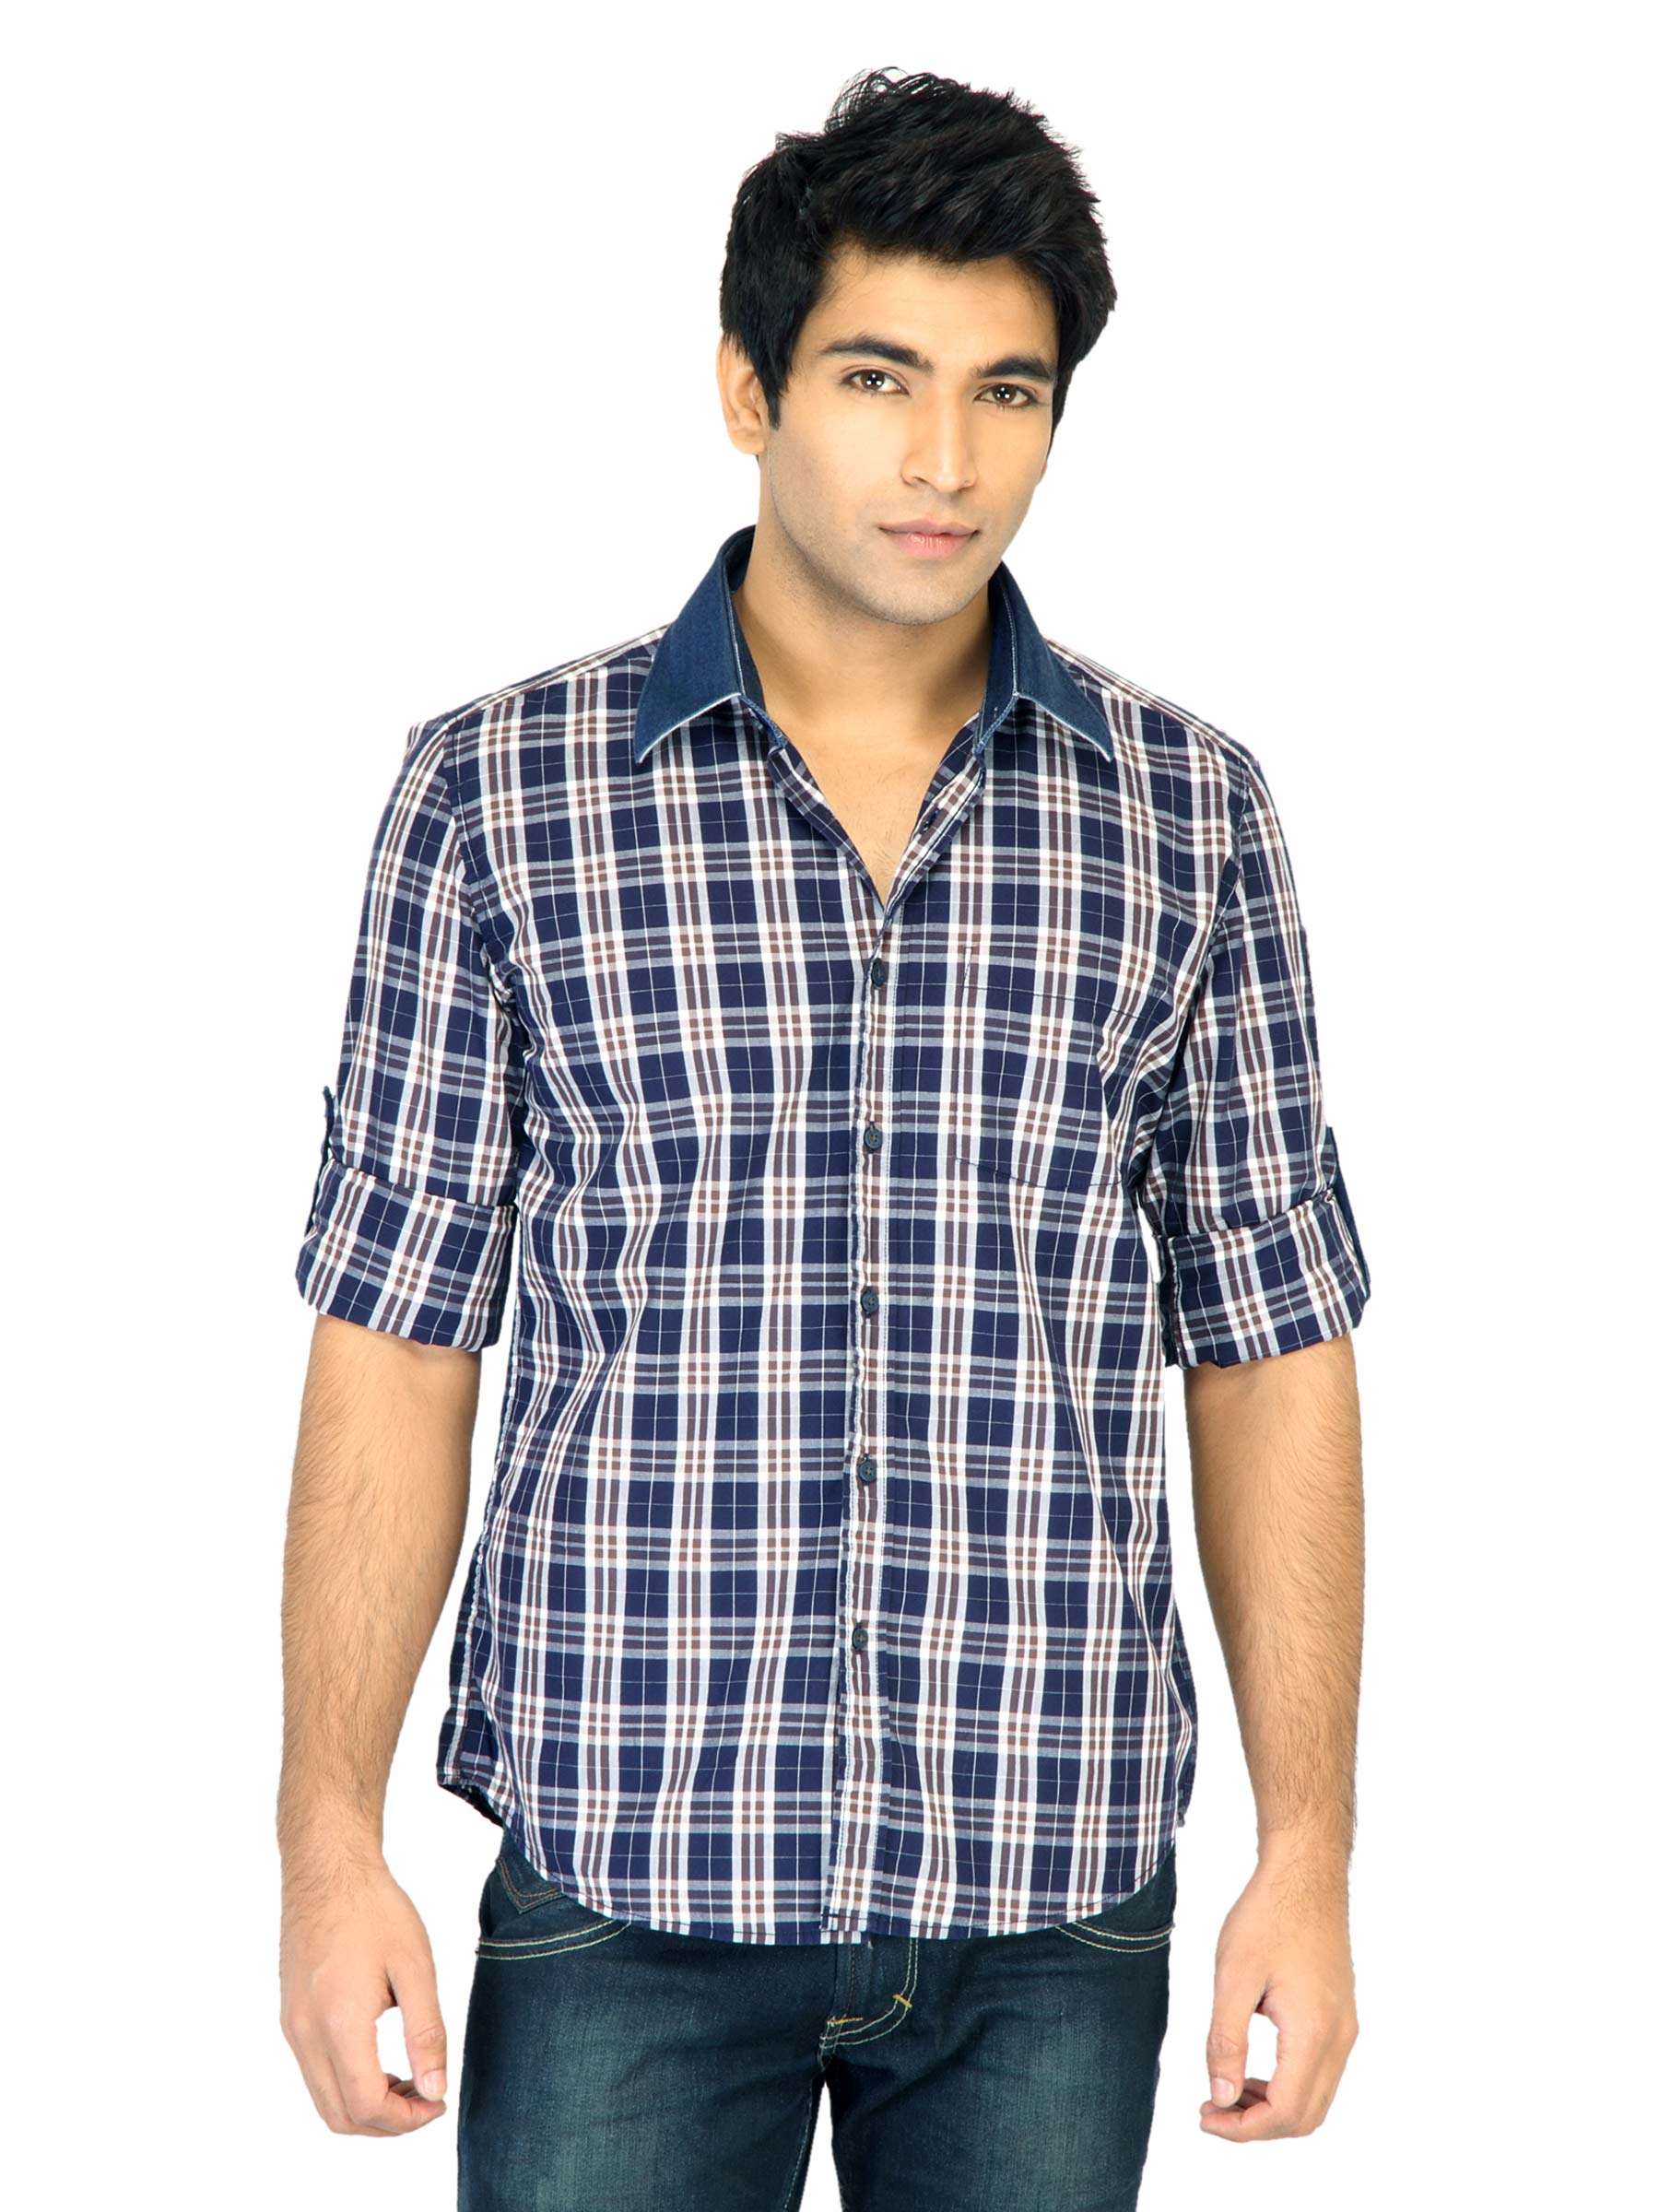

In [27]:
#Load one of the images to check is dimensions
sample_image_filename = data.iloc[0].filename
sample_image_fullname = f'{images_dir}/{sample_image_filename}'
sample_image_displayName =  data.iloc[0].productDisplayName
sample_image_articleType = data.iloc[0].articleType
img = load_img(sample_image_fullname)

print(f'Displaying image corresponding to the article \'{sample_image_displayName}\' of type \'{sample_image_articleType}\'')
img

In [28]:
x=np.array(img)
x.shape

(2400, 1800, 3)

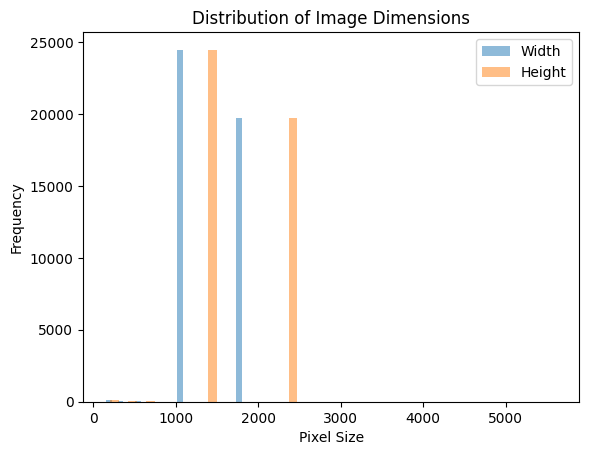

In [29]:
#Analyzing distribution of image dimensions
width, height = zip(*image_sizes)
plt.hist(width, bins=50, alpha=0.5, label='Width')
plt.hist(height, bins=50, alpha=0.5, label='Height')
plt.xlabel('Pixel Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

In [30]:
#Here we have a different in respect to the smaller dataset. In the smaller dataset all the images had the same dimensions
print("\nImages with less than 1000 pixels:")
for filename, dimensions in small_images:
    print(f"{filename}: {dimensions}")


Images with less than 1000 pixels:
47508.jpg: (540, 720)
2244.jpg: (540, 720)
10250.jpg: (150, 200)
3192.jpg: (150, 200)
30251.jpg: (150, 200)
42678.jpg: (540, 720)
6643.jpg: (540, 720)
2673.jpg: (150, 200)
7133.jpg: (540, 720)
29524.jpg: (150, 200)
3193.jpg: (150, 200)
35915.jpg: (514, 644)
5404.jpg: (150, 200)
5403.jpg: (150, 200)
2672.jpg: (150, 200)
46016.jpg: (540, 720)
2964.jpg: (540, 720)
15859.jpg: (150, 200)
2738.jpg: (360, 480)
15850.jpg: (150, 200)
2707.jpg: (360, 480)
5374.jpg: (150, 200)
16080.jpg: (150, 200)
15857.jpg: (150, 200)
5387.jpg: (150, 200)
5373.jpg: (150, 200)
2700.jpg: (360, 480)
1919.jpg: (150, 200)
3229.jpg: (150, 200)
2753.jpg: (360, 480)
6338.jpg: (150, 200)
2762.jpg: (360, 480)
13138.jpg: (360, 480)
15856.jpg: (150, 200)
2701.jpg: (360, 480)
15869.jpg: (150, 200)
5386.jpg: (150, 200)
15851.jpg: (150, 200)
2706.jpg: (360, 480)
5375.jpg: (150, 200)
5388.jpg: (150, 200)
3629.jpg: (150, 200)
11259.jpg: (150, 200)
15858.jpg: (150, 200)
2730.jpg: (360, 480)
27

Displaying image corresponding to the article '43254    Murcia Women Office Brown Bag
Name: productDisplayName, dtype: object' of type '43254    Handbags
Name: articleType, dtype: object'


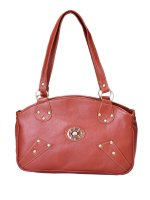

In [31]:
#The smallest pictures are 150x200 in size, like these ones
small_image_data = data[data['filename']=='2655.jpg']
sample_small_image_fullname = f"{images_dir}/{small_image_data['filename'].values[0]}"
sample_small_image_displayName =  small_image_data['productDisplayName']
sample_small_image_articleType = small_image_data['articleType']
img = load_img(sample_small_image_fullname)

print(f'Displaying image corresponding to the article \'{sample_small_image_displayName}\' of type \'{sample_small_image_articleType}\'')
img

In [32]:
# Filter the article types to keep only those with more than 4 samples 
#(we need at least 1 sample in each dataframe: train, val and test and with a small quantity of samples, it is difficult to achieve)
sub_category_counts =data.groupby('articleType').size().reset_index(name='count')
valid_article_types = sub_category_counts[sub_category_counts['count'] >= 4]['articleType']
data_cleaned = data_cleaned[data_cleaned['articleType'].isin(valid_article_types)]

In [33]:
num_classes = data_cleaned['articleType'].nunique()
num_classes

128

In [34]:
#we have the exact amount of classes we had for the smaller dataset

In [35]:
#split the data into training, validation and test datasets
full_train_df, test_df = train_test_split(data_cleaned, test_size=0.2, random_state=42, stratify=data_cleaned['articleType'])
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=42, stratify=full_train_df['articleType'])

In [36]:
# Summary of the splits
print("Training Data Shape:", train_df.shape)
print("Validation Data Shape:", val_df.shape)
print("Test Data Shape:", test_df.shape)

Training Data Shape: (26649, 7)
Validation Data Shape: (8883, 7)
Test Data Shape: (8883, 7)


In [37]:
print("Unique classes in training dataset:")
print(train_df['articleType'].value_counts())

print("\nUnique classes in validation dataset:")
print(val_df['articleType'].value_counts())

print("\nUnique classes in test dataset:")
print(test_df['articleType'].value_counts())


Unique classes in training dataset:
articleType
Tshirts             4241
Shirts              1929
Casual Shoes        1708
Watches             1525
Sports Shoes        1222
                    ... 
Beauty Accessory       2
Makeup Remover         2
Lip Plumper            2
Robe                   2
Lehenga Choli          2
Name: count, Length: 128, dtype: int64

Unique classes in validation dataset:
articleType
Tshirts            1414
Shirts              643
Casual Shoes        569
Watches             508
Sports Shoes        407
                   ... 
Lehenga Choli         1
Eye Cream             1
Nail Essentials       1
Umbrellas             1
Nehru Jackets         1
Name: count, Length: 128, dtype: int64

Unique classes in test dataset:
articleType
Tshirts             1414
Shirts               643
Casual Shoes         569
Watches              509
Sports Shoes         407
                    ... 
Wristbands             1
Headband               1
Lehenga Choli          1
Beauty Accesso

# Training the model

In [38]:
# defining a target size for images
TARGET_SIZE = (320, 320)
#defining a batch size
BATCH_SIZE=16
#defining a max queue size (count of batches preloaded in the queue while the model is training)
MAX_QUEUE_SIZE=10
#setting dir to store models
MODELS_DIR = '../models'
#setting constants to fix hyperparameters
LEARNING_RATE=0.0001
INNER_LAYER_UNITS= 1280
DROPRATE=0.5

In [39]:
# calculating how many workers threads for loading data
##warning: it is not certain that these parameters are being used by the ImageDataGenerator
num_cores = os.cpu_count()
workers = int(num_cores / 2)
use_multiprocessing=False
if workers>1:
   use_multiprocessing=True

In [40]:
#Read images by using ImageDataGenerator (by using the same paremeters used in notebook1, except for the target size)
train_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
train_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=images_dir, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,                
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 26649 validated image filenames belonging to 128 classes.


In [41]:
val_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
val_gen = val_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=images_dir, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False,
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8883 validated image filenames belonging to 128 classes.


In [42]:
test_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
test_gen = test_image_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=images_dir, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False,
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8883 validated image filenames belonging to 128 classes.


In [43]:
#Defining model with the architecture that was selected in notebook 1
def make_model(num_classes, learning_rate, inner_layer_units, droprate):
    
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu')(vectors)

    #dropout for inner layer 1
    drop = keras.layers.Dropout(droprate)(inner)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=num_classes, activation='softmax')(drop)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [44]:
#Defining function to delete any previously saved files
def delete_previous_checkpoint_files(filename_pattern):
    # Compile the regex pattern
    regex = re.compile(filename_pattern)
    
    # List all files in the specified directory
    files = os.listdir(MODELS_DIR)

    # Filter files matching the regex pattern
    matching_files = [f for f in files if regex.match(f)]
    
    # Check if there are matching files
    if not matching_files:
        print("No matching files found for deletion.")
        return 

    # Iterate through the matching files and delete them
    for checkpoint_file in matching_files:
        full_file_path = os.path.join(MODELS_DIR, checkpoint_file)
        try:
            os.remove(full_file_path)  # Attempt to delete the file
            print(f"Deleted checkpoint file: {checkpoint_file}")
        except Exception as e:
            print(f"Error deleting file {full_file_path}: {e}")

In [45]:
#Define class for a custom checkpoint
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_accuracy = 0.0
        self.best_model_file = ""

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)  # Call the parent method
        current_val_accuracy = logs.get('val_accuracy')

        if current_val_accuracy > self.best_accuracy:
            # Update best values
            self.best_accuracy = current_val_accuracy
            self.best_model_file = self.filepath.format(epoch=epoch+1, **logs)
            print(f"New best model saved at epoch {epoch+1} with validation accuracy {self.best_accuracy:.3f}.Filename:{self.best_model_file}")

In [46]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'classification_model_.*\.keras')
print(f'\nTraining the model with augmentation\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/classification_model_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

model = model = make_model(num_classes=num_classes, learning_rate=LEARNING_RATE, inner_layer_units=INNER_LAYER_UNITS, droprate=DROPRATE)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)


Deleting files previously saved to output directory

No matching files found for deletion.

Training the model with augmentation



I0000 00:00:1735857933.766344  201431 service.cc:148] XLA service 0x301c1bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735857933.766635  201431 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1735857935.335806  201431 service.cc:148] XLA service 0x2c2b5a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735857935.335824  201431 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
I0000 00:00:1735857935.352967  201431 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1735857935.358872  201431 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2245 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/10


2025-01-02 17:45:42.747740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735857943.421668  201605 cuda_dnn.cc:529] Loaded cuDNN version 90600
E0000 00:00:1735857945.624215  201605 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735857945.861422  201605 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735857946.098796  201605 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735857946.337982  201605 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missi

   2/1666 ━━━━━━━━━━━━━━━━━━━━ 1:24 51ms/step - accuracy: 0.0000e+00 - loss: 4.9607  

I0000 00:00:1735857949.826778  201605 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 341/1666 ━━━━━━━━━━━━━━━━━━━━ 5:03 229ms/step - accuracy: 0.3972 - loss: 2.9288

E0000 00:00:1735858029.534088  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735858029.778346  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735858030.024890  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1666/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6115 - loss: 1.7574  

E0000 00:00:1735858488.364027  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735858488.576179  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735858488.754207  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735858488.933368  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735858489.108549  201606 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-02

New best model saved at epoch 1 with validation accuracy 0.818.Filename:../models/classification_model_01_0.818.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 555s 326ms/step - accuracy: 0.6116 - loss: 1.7570 - val_accuracy: 0.8179 - val_loss: 0.6385
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.839.Filename:../models/classification_model_02_0.839.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 503s 302ms/step - accuracy: 0.8125 - loss: 0.6413 - val_accuracy: 0.8389 - val_loss: 0.5288
Epoch 3/10
New best model saved at epoch 3 with validation accuracy 0.850.Filename:../models/classification_model_03_0.850.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 507s 305ms/step - accuracy: 0.8419 - loss: 0.5137 - val_accuracy: 0.8499 - val_loss: 0.4804
Epoch 4/10
New best model saved at epoch 4 with validation accuracy 0.856.Filename:../models/classification_model_04_0.856.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 495s 297ms/step - accuracy: 0.8632 - loss: 0.4262 - val_accuracy: 0.8557 - val_loss: 0.4447
Epo

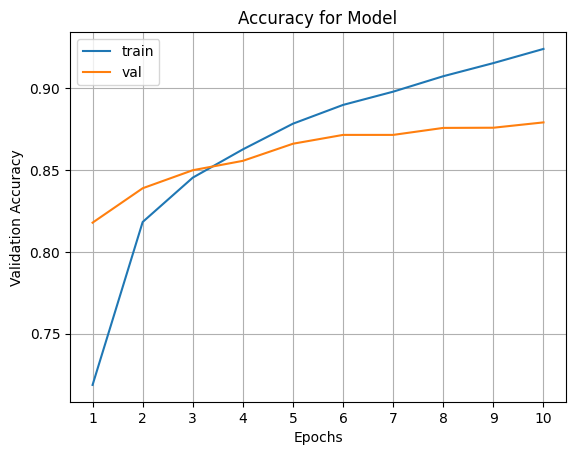

In [47]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.title('Accuracy for Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

num_epochs = len(history.history['val_accuracy'])  
plt.xticks(np.arange(num_epochs), np.arange(1, num_epochs + 1)) 
plt.legend()
plt.grid()
plt.show()

In [48]:
validation_accuracy = round(custom_checkpoint.best_accuracy, 4)
model_filename= custom_checkpoint.best_model_file
print(f"Best Validation Accuracy for model: {validation_accuracy}")
print(f"Saved Model File: {model_filename}")

Best Validation Accuracy for model: 0.8792
Saved Model File: ../models/classification_model_10_0.879.keras


In [49]:
## The model on epoch 10 which is the one with better performance, but the gap between validation and training 
# accuracy might be suggesting a certain degree of overfitting, so we need to calculate the accuracy on the testing dataset

# Retraning the model

In [50]:
#Retraining the model on the train+validation dataset
full_train_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
full_train_gen = full_train_image_gen.flow_from_dataframe(
    dataframe=full_train_df,
    directory=images_dir, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,                
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)



Found 35532 validated image filenames belonging to 128 classes.


In [51]:
model = make_model(num_classes=num_classes, learning_rate=LEARNING_RATE, inner_layer_units=INNER_LAYER_UNITS, droprate=DROPRATE)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=None
)

Epoch 1/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 354s 209ms/step - accuracy: 0.6175 - loss: 1.7359
Epoch 2/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 342s 205ms/step - accuracy: 0.8118 - loss: 0.6476
Epoch 3/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 347s 208ms/step - accuracy: 0.8456 - loss: 0.5099
Epoch 4/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 348s 209ms/step - accuracy: 0.8648 - loss: 0.4283
Epoch 5/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 347s 208ms/step - accuracy: 0.8795 - loss: 0.3700
Epoch 6/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 345s 207ms/step - accuracy: 0.8911 - loss: 0.3381
Epoch 7/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 348s 209ms/step - accuracy: 0.9041 - loss: 0.2906
Epoch 8/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 340s 208ms/step - accuracy: 0.9113 - loss: 0.2710
Epoch 9/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 347s 208ms/step - accuracy: 0.9203 - loss: 0.2411
Epoch 10/10
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 348s 209ms/step - accuracy: 0.9224 - loss: 0.2338


# Evaluating the model

In [52]:
#clear any unused session
tf.keras.backend.clear_session()

In [53]:
model_file_path = f'{MODELS_DIR}/{model_filename}'

In [54]:
model = keras.models.load_model(model_file_path)

In [55]:
test_loss, test_accuracy = model.evaluate(test_gen)
test_accuracy

556/556 ━━━━━━━━━━━━━━━━━━━━ 132s 232ms/step - accuracy: 0.8804 - loss: 0.3724


0.8793200254440308

In [56]:
##Conclusion: The model did not overfit; it achieved good accuracy on the test dataset, which was very similar to the accuracy on the validation dataset

In [57]:
#rename the file with the model that will be used as the final one
new_model_file_path = f'{MODELS_DIR}/final_classification_model.keras'
os.rename(model_file_path, new_model_file_path)
print(f"Model file:{new_model_file_path}")

Model file:../models/final_classification_model.keras


In [58]:
# Calculate time it took to run the notebook
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = round(total_time_seconds / 60)

print(f"Total execution time for this notebook: {total_time_minutes} minutes")

Total execution time for this notebook: 142 minutes
